# Neural Networks

## Sets imports and formatting

We begin by importing the necessary modules.

In [51]:
import pandas as pd
import numpy as np
import csv
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from livelossplot import PlotLossesKeras
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

We import the data and create `X` and `y` sets.

In [52]:
campaign_ad = pd.read_csv("MLUnige2023_subscriptions_train.csv", index_col="Id")
campaign_test = pd.read_csv("MLUnige2023_subscriptions_test.csv", index_col="Id")

X = campaign_ad.drop(columns='subscription')
y = campaign_ad['subscription']

# list of variables coded as strings
cat_vars_strings = ['job', 'marital', 'education', 'device', 'outcome_old']

We split the data into training, validation and test sets.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=46)

As we will see when building our neural network, it will require the input to be in a specific format which corresponds to its architecture. For this purpose, we create versions of `X_train`, `X_valid`, `X_test`, `X` and `campaign_test` which are suitable for our neural network.

In [54]:
X_train_input = [X_train['job'],
                 X_train['marital'],
                 X_train['education'],
                 X_train['device'],
                 X_train['outcome_old'],
                 X_train.drop(columns=cat_vars_strings)]

In [55]:
X_valid_input = [X_valid['job'],
                 X_valid['marital'],
                 X_valid['education'],
                 X_valid['device'],
                 X_valid['outcome_old'],
                 X_valid.drop(columns=cat_vars_strings)]

In [56]:
X_test_input =  [X_test['job'],
                 X_test['marital'],
                 X_test['education'],
                 X_test['device'],
                 X_test['outcome_old'],
                 X_test.drop(columns=cat_vars_strings)]

In [57]:
X_input = [X['job'],
           X['marital'],
           X['education'],
           X['device'],
           X['outcome_old'],
           X.drop(columns=cat_vars_strings)]

In [58]:
campaign_test_input = [campaign_test['job'],
                       campaign_test['marital'],
                       campaign_test['education'],
                       campaign_test['device'],
                       campaign_test['outcome_old'],
                       campaign_test.drop(columns=cat_vars_strings)]

## Grid Search

We will use the grid search to tune some hyperparameters of our model. However, we first build its architecture inside the following function.

The general idea is that each categorical feature which is coded as string inside our dataset will be preprocessed separately by the neural network. A `StringLookup` layer first translates the strings into integers, assigning a number to each different value of the categorical variable. It also defines an integer value which will stand for any string that is not one of the predefined levels of the variable. The `Embedding` layer takes as input the integer values and creates a vector for each. The output dimension allows to control of which length the vectors of each word will be.

For example, job has 12 levels (or words). `StringLookup` will assign them 13 integer values, from 0 to 12. Embedding will create a vector of length `output_dim` for each integer value. Each coordinate of the vectors will have its associated weight. In particular for job, which has the biggest number of levels, the value of the output dimension will be tuned using the grid search. This is a technique to reduce dimensions implicitely inside categorical variables which have multiple levels.

Once all string categorical variables have gone through this process, a merging layer will combine all of these parallel inputs, together with the rest of the dataset features. Those features will have been scaled using a Normalization layer.

After the merge, we have a regular multilayer perceptron with layers slowly decreasing in node size until the output.

In [ ]:
def build_model(hp):
    # JOB INPUT
    n_levels_job = len(X['job'].unique())
    input_job       = layers.Input(name='input_job', shape=(1,), dtype='string')
    str_to_ints_job = layers.StringLookup(name='str_to_ints_job', vocabulary=X['job'].unique())(input_job)
    embed_vecs_job  = layers.Embedding(name='embed_vecs_job',
                                    input_dim=n_levels_job + 1,
                                    output_dim=hp.get('output_job'))(str_to_ints_job)
    flat_job        = layers.Flatten(name='flat_job')(embed_vecs_job)

    # MARITAL INPUT
    n_levels_marital = len(X['marital'].unique())
    input_marital       = layers.Input(name='input_marital', shape=(1,), dtype='string')
    str_to_ints_marital = layers.StringLookup(name='str_to_ints_marital', vocabulary=X['marital'].unique())(input_marital)
    embed_vecs_marital  = layers.Embedding(name='embed_vecs_marital',
                                        input_dim=n_levels_marital + 1,
                                        output_dim=n_levels_marital)(str_to_ints_marital)
    flat_marital        = layers.Flatten(name='flat_marital')(embed_vecs_marital)

    # EDUCATION INPUT
    n_levels_education = len(X['education'].unique())
    input_education       = layers.Input(name='input_education', shape=(1,), dtype='string')
    str_to_ints_education = layers.StringLookup(name='str_to_ints_education', vocabulary=X['education'].unique())(input_education)
    embed_vecs_education  = layers.Embedding(name='embed_vecs_education',
                                            input_dim=n_levels_education + 1,
                                            output_dim=n_levels_education)(str_to_ints_education)
    flat_education        = layers.Flatten(name='flat_education')(embed_vecs_education)

    # DEVICE INPUT
    n_levels_device = len(X['device'].unique())
    input_device       = layers.Input(name='input_device', shape=(1,), dtype='string')
    str_to_ints_device = layers.StringLookup(name='str_to_ints_device', vocabulary=X['device'].unique())(input_device)
    embed_vecs_device  = layers.Embedding(name='embed_vecs_device',
                                        input_dim=n_levels_device + 1,
                                        output_dim=2)(str_to_ints_device)
    flat_device        = layers.Flatten(name='flat_device')(embed_vecs_device)

    # OUTCOME_OLD INPUT
    n_levels_outcome_old = len(X['outcome_old'].unique())
    input_outcome_old       = layers.Input(name='input_outcome_old', shape=(1,), dtype='string')
    str_to_ints_outcome_old = layers.StringLookup(name='str_to_ints_outcome_old', vocabulary=X['outcome_old'].unique())(input_outcome_old)
    embed_vecs_outcome_old  = layers.Embedding(name='embed_vecs_outcome_old',
                                            input_dim=n_levels_outcome_old + 1,
                                            output_dim=2)(str_to_ints_outcome_old)
    flat_outcome_old        = layers.Flatten(name='flat_outcome_old')(embed_vecs_outcome_old)

    # NUMERIC INPUTS
    num_inputs = layers.Input(name='num_inputs', shape=(11,))
    num_norm = layers.Normalization(name='num_norm', axis=1)(num_inputs)

    # MERGING INPUTS
    merged = layers.concatenate([flat_job,
                                flat_marital,
                                flat_education,
                                flat_device,
                                flat_outcome_old,
                                num_norm],
                                name='merged')

    # DENSE LAYERS
    dense1 = layers.Dense(name='dense1', units=hp.get('dense1_nodes'), activation='relu')(merged)
    dense2 = layers.Dense(name='dense2', units=16, activation='relu')(dense1)
    dense3 = layers.Dense(name='dense3', units=8, activation='relu')(dense2)
    dense4 = layers.Dense(name='dense4', units=4, activation='relu')(dense3)
    output = layers.Dense(name='output', units=1, activation='sigmoid')(dense4)

    # MODEL
    model = keras.Model(inputs=[input_job, input_marital, input_education, input_device, input_outcome_old, num_inputs],
                        outputs=[output])
    
    model.compile(loss = 'binary_crossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate=hp.get('learning_rate')),
                  metrics= ['accuracy'])
    
    return model

The model has been defined above, and we have incorporated three hyperparameters that we will tune:
- The length of the output vectors for job
- The number of nodes in the first dense layer
- The learning rate of the optimizer

Their respective grid of values is defined below.

In [ ]:
hp = HyperParameters()
hp.Choice('output_job', [12,9,6,3,1]);
hp.Choice('dense1_nodes', [64,32,16]);
hp.Choice('learning_rate', [0.0001, 0.001, 0.01, 0.1]);

Now, we can build the `RandomSearch` object. The `max_trials` parameter controls the number of different model configurations which are tried out. We set the `objective` to be the accuracy of the validation set.

In [ ]:
tuner = RandomSearch(hypermodel = build_model,
                     hyperparameters=hp,
                     max_trials=60, 
                     objective="val_accuracy", 
                     allow_new_entries=False)

We are now ready to proceed with the grid search. After different having tried out 32, 64, and 128 as `batch_size`, a size of 64 seems to give better results. The number of epochs is set to 100, but we also implement early stopping which prevents us from continuing training a model which shows no significative improvement. The `PlotLossesKeras` function allows to have live evolving plots of the accuracy and the loss function as models are tried out.

In [ ]:
tuner.search(x=X_train_input, y=y_train,
             validation_data=(X_valid_input, y_valid),
             batch_size=64,
             epochs=100,
             shuffle=True,
             callbacks=[PlotLossesKeras(), keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)])

Trial 9 Complete [00h 00m 27s]
val_accuracy: 0.8168280124664307

Best val_accuracy So Far: 0.8220402002334595
Total elapsed time: 00h 04m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Show a summary of the search
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
output_job: 6
dense1_nodes: 64
Score: 0.8220402002334595

Trial 02 summary
Hyperparameters:
output_job: 3
dense1_nodes: 64
Score: 0.8198063969612122

Trial 04 summary
Hyperparameters:
output_job: 1
dense1_nodes: 32
Score: 0.818317174911499

Trial 08 summary
Hyperparameters:
output_job: 6
dense1_nodes: 16
Score: 0.8168280124664307

Trial 00 summary
Hyperparameters:
output_job: 3
dense1_nodes: 16
Score: 0.8145942091941833

Trial 06 summary
Hyperparameters:
output_job: 1
dense1_nodes: 16
Score: 0.8138495683670044

Trial 05 summary
Hyperparameters:
output_job: 3
dense1_nodes: 32
Score: 0.8131049871444702

Trial 03 summary
Hyperparameters:
output_job: 1
dense1_nodes: 64
Score: 0.8116157650947571

Trial 01 summary
Hyperparameters:
output_job: 6
dense1_nodes: 32
Score: 0.5778108835220337


In [ ]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
a = tuner.get_best_hyperparameters(num_trials=1)[0]
a.get('dense1_nodes')

64

In [ ]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test_input, y_test)

42/42 [==============================] - 0s 2ms/step - loss: 0.3910 - accuracy: 0.8354


# Neural Net construction

We use the following function to set one seed globally for the whole neural network.

In [59]:
keras.utils.set_random_seed(493)

In [60]:
n_levels_job = len(X['job'].unique())

input_job       = layers.Input(name='input_job', shape=(1,), dtype='string')
str_to_ints_job = layers.StringLookup(name='str_to_ints_job', vocabulary=X['job'].unique())(input_job)
embed_vecs_job  = layers.Embedding(name='embed_vecs_job',
                                   input_dim=n_levels_job + 1,
                                   output_dim=6)(str_to_ints_job)
flat_job        = layers.Flatten(name='flat_job')(embed_vecs_job)

In [61]:
n_levels_marital = len(X['marital'].unique())

input_marital       = layers.Input(name='input_marital', shape=(1,), dtype='string')
str_to_ints_marital = layers.StringLookup(name='str_to_ints_marital', vocabulary=X['marital'].unique())(input_marital)
embed_vecs_marital  = layers.Embedding(name='embed_vecs_marital',
                                       input_dim=n_levels_marital + 1,
                                       output_dim=n_levels_marital)(str_to_ints_marital)
flat_marital        = layers.Flatten(name='flat_marital')(embed_vecs_marital)

In [62]:
n_levels_education = len(X['education'].unique())

input_education       = layers.Input(name='input_education', shape=(1,), dtype='string')
str_to_ints_education = layers.StringLookup(name='str_to_ints_education', vocabulary=X['education'].unique())(input_education)
embed_vecs_education  = layers.Embedding(name='embed_vecs_education',
                                         input_dim=n_levels_education + 1,
                                         output_dim=n_levels_education)(str_to_ints_education)
flat_education        = layers.Flatten(name='flat_education')(embed_vecs_education)

In [63]:
n_levels_device = len(X['device'].unique())

input_device       = layers.Input(name='input_device', shape=(1,), dtype='string')
str_to_ints_device = layers.StringLookup(name='str_to_ints_device', vocabulary=X['device'].unique())(input_device)
embed_vecs_device  = layers.Embedding(name='embed_vecs_device',
                                      input_dim=n_levels_device + 1,
                                      output_dim=2)(str_to_ints_device)
flat_device        = layers.Flatten(name='flat_device')(embed_vecs_device)

In [64]:
n_levels_outcome_old = len(X['outcome_old'].unique())

input_outcome_old       = layers.Input(name='input_outcome_old', shape=(1,), dtype='string')
str_to_ints_outcome_old = layers.StringLookup(name='str_to_ints_outcome_old', vocabulary=X['outcome_old'].unique())(input_outcome_old)
embed_vecs_outcome_old  = layers.Embedding(name='embed_vecs_outcome_old',
                                           input_dim=n_levels_outcome_old + 1,
                                           output_dim=2)(str_to_ints_outcome_old)
flat_outcome_old        = layers.Flatten(name='flat_outcome_old')(embed_vecs_outcome_old)

In [65]:
num_inputs = layers.Input(name='num_inputs', shape=(11,))
num_norm = layers.Normalization(name='num_norm', axis=1)(num_inputs)

merged = layers.concatenate([flat_job,
                             flat_marital,
                             flat_education,
                             flat_device,
                             flat_outcome_old,
                             num_norm],
                             name='merged')

dense1 = layers.Dense(name='dense1', units=64, activation='relu')(merged)
dense2 = layers.Dense(name='dense2', units=32, activation='relu')(dense1)
dense3 = layers.Dense(name='dense3', units=16, activation='relu')(dense2)
dense4 = layers.Dense(name='dense4', units=8, activation='relu')(dense3)
dense5 = layers.Dense(name='dense5', units=4, activation='relu')(dense4)
output = layers.Dense(name='output', units=1, activation='sigmoid')(dense5)

In [66]:
model = keras.Model(inputs=[input_job, input_marital, input_education, input_device, input_outcome_old, num_inputs],
                    outputs=[output])

# Neural Net Visualization

In [67]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_job (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 input_marital (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 input_education (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 input_device (InputLayer)      [(None, 1)]          0           []                               
                                                                                            

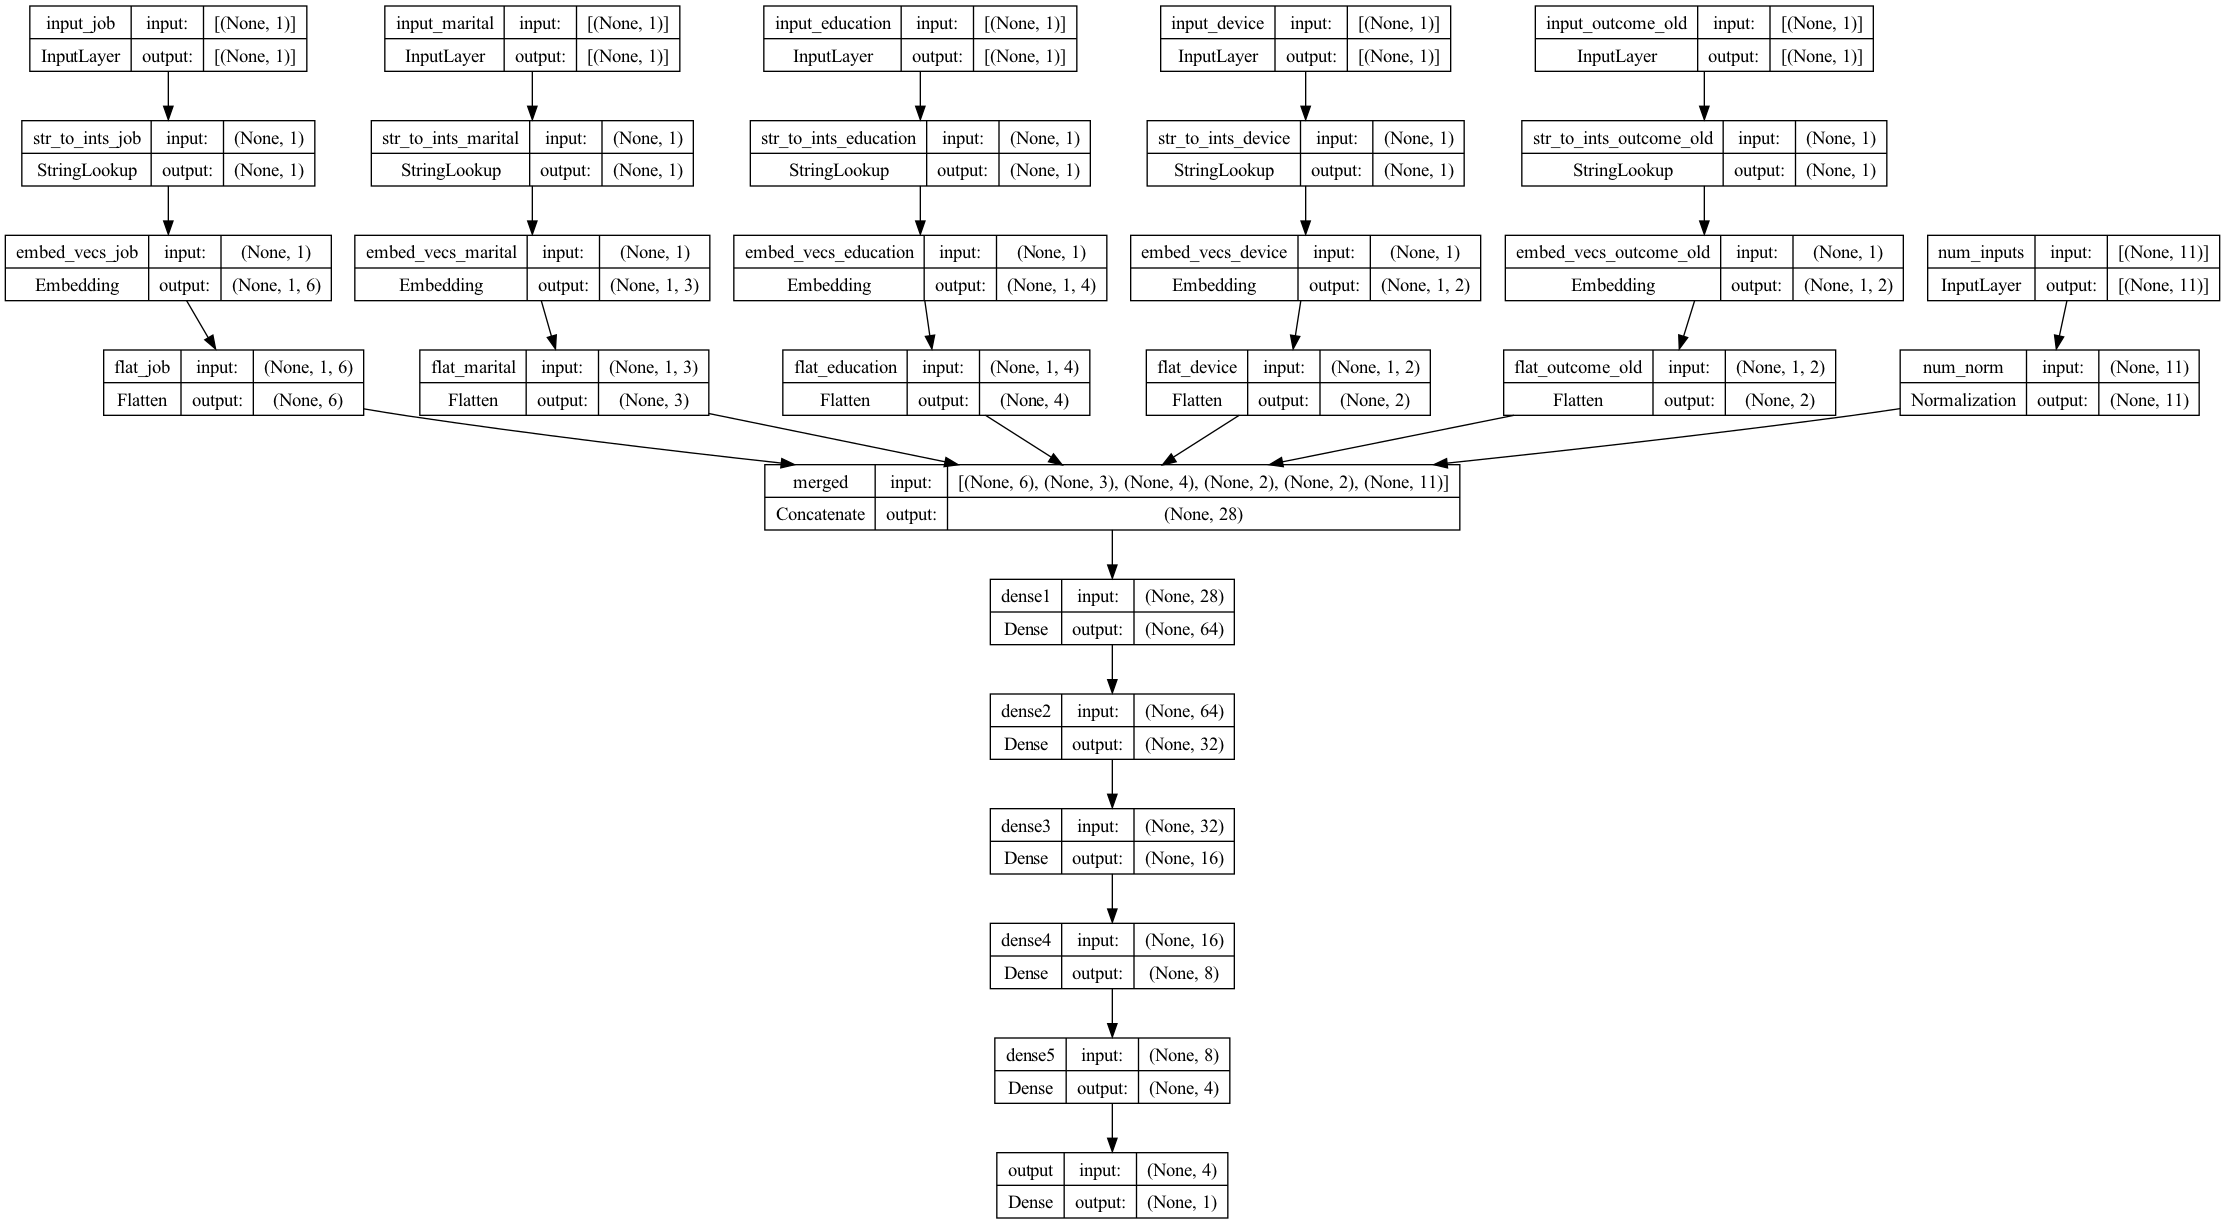

In [68]:
keras.utils.plot_model(model, show_shapes=True)

# Model compilation and fit

In [69]:
model.compile(loss = 'binary_crossentropy',
              optimizer = keras.optimizers.Adam(learning_rate=0.0001),
              metrics= ['accuracy'])

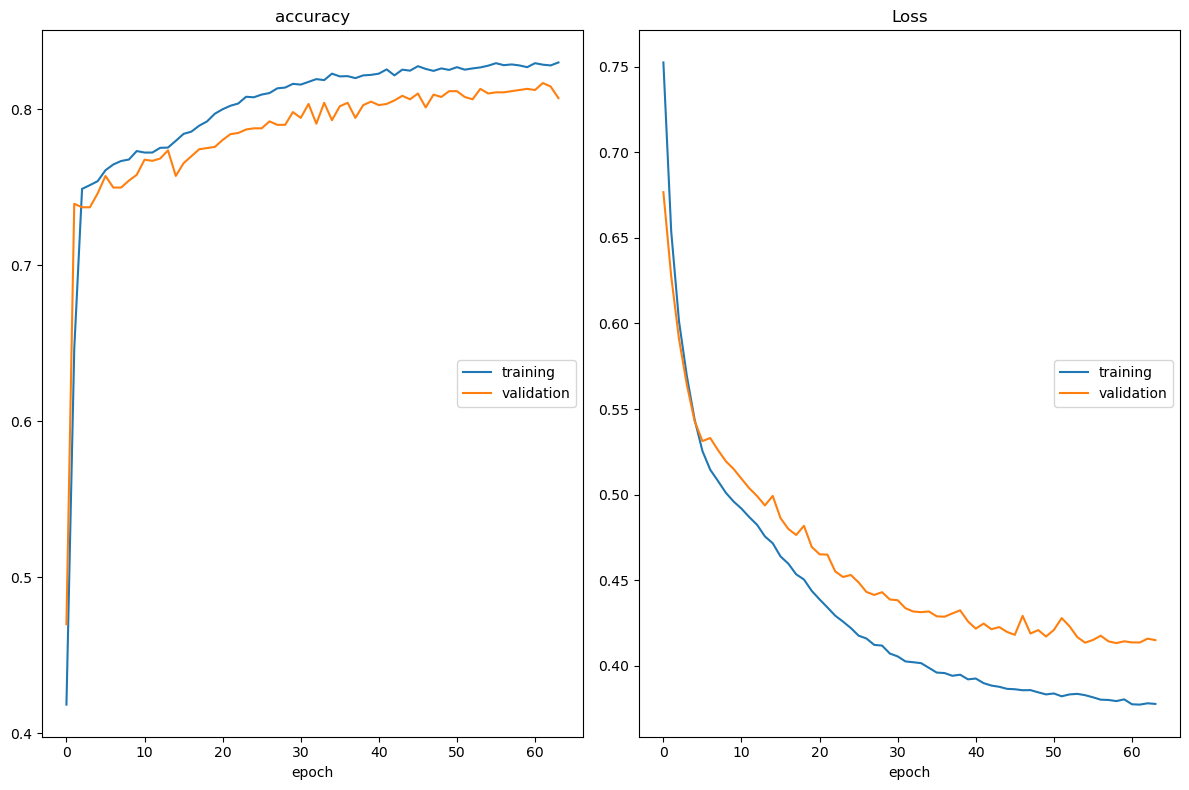

accuracy
	training         	 (min:    0.418, max:    0.830, cur:    0.830)
	validation       	 (min:    0.470, max:    0.817, cur:    0.807)
Loss
	training         	 (min:    0.377, max:    0.753, cur:    0.378)
	validation       	 (min:    0.413, max:    0.677, cur:    0.415)
98/98 [==============================] - 1s 11ms/step - loss: 0.3776 - accuracy: 0.8300 - val_loss: 0.4149 - val_accuracy: 0.8071


In [70]:
fit_history = model.fit(x=X_train_input, y=y_train, 
                        validation_data=(X_valid_input, y_valid),
                        batch_size=64,
                        epochs=100,
                        shuffle=True,
                        callbacks=[PlotLossesKeras(), keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

In [71]:
model.evaluate(X_train_input, y_train)

196/196 [==============================] - 0s 2ms/step - loss: 0.3773 - accuracy: 0.8284


[0.3772937059402466, 0.8284391760826111]

In [72]:
model.evaluate(X_valid_input, y_valid)

42/42 [==============================] - 0s 2ms/step - loss: 0.4149 - accuracy: 0.8071


[0.4148833751678467, 0.8071481585502625]

In [39]:
model.evaluate(X_test_input, y_test)

42/42 [==============================] - 0s 2ms/step - loss: 0.3865 - accuracy: 0.8384


[0.3864672780036926, 0.8384214639663696]

# Cutoff search

In [73]:
train_probas = model.predict(X_train_input)
valid_probas = model.predict(X_valid_input)
test_probas = model.predict(X_test_input)

cutoff_table = pd.DataFrame({'cutoff': 1e-2*np.arange(10, 95, 5)})
cutoff_table['train_acc'] = [np.round(accuracy_score(y_train, (train_probas > cutoff).astype(int)), 3)
                             for cutoff in cutoff_table['cutoff']]
cutoff_table['valid_acc'] = [np.round(accuracy_score(y_valid, (valid_probas > cutoff).astype(int)), 3)
                             for cutoff in cutoff_table['cutoff']]
cutoff_table['test_acc'] = [np.round(accuracy_score(y_test, (test_probas > cutoff).astype(int)), 3)
                             for cutoff in cutoff_table['cutoff']]
cutoff_table

42/42 [==============================] - 0s 3ms/step


,cutoff,train_acc,valid_acc,test_acc
0,0.10,0.676,0.664,0.646
1,0.15,0.721,0.709,0.707
2,0.20,0.758,0.738,0.747
3,0.25,0.782,0.759,0.774
4,0.30,0.798,0.777,0.801
5,0.35,0.807,0.785,0.820
6,0.40,0.817,0.794,0.831
7,0.45,0.823,0.800,0.832
8,0.50,0.828,0.807,0.838
9,0.55,0.831,0.812,0.837


In [74]:
cutoff_table = pd.DataFrame({'cutoff': 1e-2*np.arange(40, 65, 1)})
cutoff_table['train_acc'] = [np.round(accuracy_score(y_train, (train_probas > cutoff).astype(int)), 4)
                             for cutoff in cutoff_table['cutoff']]
cutoff_table['valid_acc'] = [np.round(accuracy_score(y_valid, (valid_probas > cutoff).astype(int)), 4)
                             for cutoff in cutoff_table['cutoff']]
cutoff_table['test_acc'] = [np.round(accuracy_score(y_test, (test_probas > cutoff).astype(int)), 4)
                             for cutoff in cutoff_table['cutoff']]
cutoff_table

,cutoff,train_acc,valid_acc,test_acc
0,0.40,0.8166,0.7945,0.8310
1,0.41,0.8192,0.7960,0.8302
2,0.42,0.8205,0.7975,0.8295
3,0.43,0.8213,0.7990,0.8340
4,0.44,0.8229,0.7990,0.8325
5,0.45,0.8230,0.8004,0.8325
6,0.46,0.8248,0.8027,0.8399
7,0.47,0.8262,0.8057,0.8354
8,0.48,0.8264,0.8057,0.8407
9,0.49,0.8267,0.8071,0.8392


In [75]:
treshold = 0.5

# Fit on whole `X` and prediction on `campaign_test`

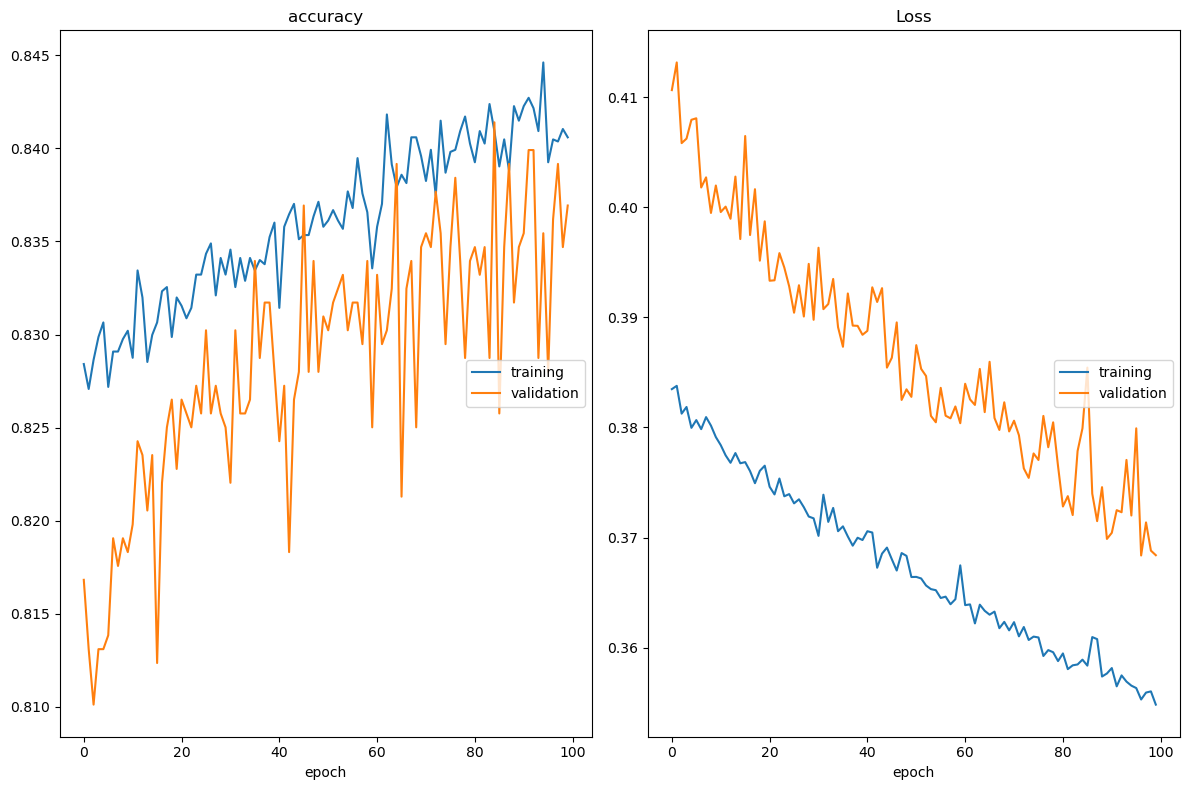

accuracy
	training         	 (min:    0.827, max:    0.845, cur:    0.841)
	validation       	 (min:    0.810, max:    0.841, cur:    0.837)
Loss
	training         	 (min:    0.355, max:    0.384, cur:    0.355)
	validation       	 (min:    0.368, max:    0.413, cur:    0.368)
140/140 [==============================] - 1s 10ms/step - loss: 0.3548 - accuracy: 0.8406 - val_loss: 0.3684 - val_accuracy: 0.8369


In [76]:
fit_history = model.fit(x=X_input, y=y, 
                   validation_data=(X_valid_input, y_valid),
                   batch_size=64,
                   epochs=100,
                   callbacks=[PlotLossesKeras()])

In [77]:
model.evaluate(X_input, y)

280/280 [==============================] - 1s 2ms/step - loss: 0.3522 - accuracy: 0.8422


[0.3521546721458435, 0.8421581983566284]

In [78]:
y_REAL_test = (model.predict(campaign_test_input) > treshold).astype(int)
y_REAL_test = y_REAL_test.ravel()
y_REAL_test

120/120 [==============================] - 0s 2ms/step


array([0, 1, 0, ..., 0, 1, 1])

In [47]:
file = open('test_file_neuralnets.csv', 'w')
writer = csv.writer(file)
writer.writerow(['Id', 'subscription'])
for i in range(len(y_REAL_test)):
    writer.writerow([i, y_REAL_test[i]])
file.close()